### Imports

In [1]:
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import time

import load_data
import load_transfer_data
import models
import modelz
import learning_rate_scheduler as lrs


print(f"TensorFlow version: {tf.__version__}")
print(tf.config.list_physical_devices("GPU"))

2024-05-09 21:36:00.610506: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 21:36:00.656339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 21:36:00.656366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 21:36:00.657760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 21:36:00.664204: I tensorflow/core/platform/cpu_feature_guar

Maximum length:  29
Vocab size:  67


2024-05-09 21:36:08.209840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 21:36:08.229622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 21:36:08.229716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 21:36:08.232061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 21:36:08.232094: I external/local_xla/xla/stream_executor

TensorFlow version: 2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-09 21:36:08.371910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Config Variables

In [2]:
from config import *

### Dataset

In [3]:
x_train_img_paths, y_train_labels = load_data.get_train_data()
#x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()
#x_train_img_paths, y_train_labels = load_transfer_data.get_train_data()
#x_val_img_paths, y_val_labels = load_transfer_data.get_validation_data()
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])

Maximum length:  93
Vocab size:  79
Training path: ['dataset/iam_dataset/lines/m06/m06-106/m06-106-03.png', 'dataset/iam_dataset/lines/a01/a01-132u/a01-132u-03.png'] ['and|Haris|there|were|many|events|.|Chief|of|these|was', 'adjust|the|financing|-|which|Mr.|Powell']
Validation path: ['dataset/iam_dataset/lines/b04/b04-034/b04-034-04.png', 'dataset/iam_dataset/lines/a05/a05-004/a05-004-05.png'] ['Newmarket|urban|council|,|says|:|"|I|shall|always|feel|this|as|a', 'and|operations|.|This|would|apply|also|in|the']


In [4]:
import tokenizer

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH, IMAGE_HEIGHT), BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels, (IMAGE_WIDTH, IMAGE_HEIGHT), BATCH_SIZE)
#test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels, (IMAGE_WIDTH, IMAGE_HEIGHT), BATCH_SIZE)
aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)

### Load Model

In [5]:
char = len(tokenizer.char_to_num.get_vocabulary())
model = modelz.build_supreme_leader(IMAGE_WIDTH, IMAGE_HEIGHT, char, LEARNING_RATE)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 1024, 128, 1)]       0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 1024, 128, 48)        480       ['image[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 1024, 128, 64)        27712     ['Conv1[0][0]']               
                                                                                                  
 Conv3 (Conv2D)              (None, 1024, 128, 96)        55392     ['Conv2[0][0]']               
                                                                             

### Learning Rate Scheduler

In [6]:
lr_scheduler = lrs.lr_scheduler(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    alpha=0.0001,
    warmup_target=None,
    warmup_steps=0,
    name="cosine_decay",
)

### Train Model

In [7]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoint.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
]

In [8]:
def train_model(model):
    """Trains the model and returns prediction model and training history.

    This function trains the provided model using the training and validation datasets.
    It also returns a prediction model and training history.

    Args:
        model: The Keras model to be trained.

    Returns:
        prediction_model: The model used for predictions.
        history: The training history.
    """
    prediction_model = tf.keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    history = model.fit(aug_train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
    history.history["lr"] = model.optimizer.lr.numpy()
    return prediction_model, history

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler())
model.compile(optimizer=optimizer)

In [1]:
start_time = time.time()
prediction_model, history = train_model(model)
total_duration = time.time() - start_time

NameError: name 'time' is not defined

### Training Loop with GradientTape (needs fixing)

In [ ]:
train_loss = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy("train_accuracy")
val_loss = tf.keras.metrics.Mean("test_loss", dtype=tf.float32)
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy("test_accuracy")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)


def validation_step(model, x_val, y_val):
    predictions = model(x_val)
    loss = loss_object(y_val, predictions)

    val_loss(loss)
    val_accuracy(y_val, predictions)

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = f"logs/custom_train_tb/{current_time}/train"
test_log_dir = f"logs/custom_train_tb/{current_time}/validation"
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
for epoch in range(EPOCHS):
    train_loss.reset_states()
    val_loss.reset_states()
    train_accuracy.reset_states()
    val_accuracy.reset_states()

    for x_train, y_train in train_ds:
        train_step(model, optimizer, x_train, y_train)
    with train_summary_writer.as_default():
        tf.summary.scalar("loss", train_loss.result(), step=epoch)
        tf.summary.scalar("accuracy", train_accuracy.result(), step=epoch)

    for x_val, y_val in val_ds:
        validation_step(model, x_val, y_val)
    with test_summary_writer.as_default():
        tf.summary.scalar("loss", val_loss.result(), step=epoch)
        tf.summary.scalar("accuracy", val_accuracy.result(), step=epoch)

    template = "Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}"
    print(
        template.format(
            epoch + 1,
            train_loss.result(),
            train_accuracy.result() * 100,
            val_loss.result(),
            val_accuracy.result() * 100,
        )
    )

for callback in callbacks:
    callback.on_epoch_end(
        epoch + 1,
        {
            "loss": train_loss.result(),
            "accuracy": train_accuracy.result(),
            "val_loss": val_loss.result(),
            "val_accuracy": val_accuracy.result(),
        },
    )

### Plot

In [11]:
from matplotlib.ticker import StrMethodFormatter


def plot_history(history, name, dir_path, save_fig):
    """Plots the training history of a model.

    This function takes the training history of a model and plots the training and validation loss
    across epochs. It also plots the learning rate on a secondary y-axis using a logarithmic scale.

    Args:
        history: The training history of the model.
        name (str): The name of the model.
        dir_path (str): The directory path to save the plot.
        save_fig (bool): A flag indicating whether to save the plot as an image.

    Returns:
        None
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics["loss"], label="Training Loss", color="blue")
    ax1.plot(metrics["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="black")
    ax1.tick_params("y", colors="black")
    ax1.legend(loc="upper left", bbox_to_anchor=(0.0, 0.95))

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    ax2.plot(metrics["lr"], label="Learning Rate", color="green")
    ax2.set_ylabel("Learning Rate", color="black")

    ax2.set_yscale("log")  # Verwende logarithmische Skala für die Lernrate

    ax2.tick_params("y", colors="black")
    ax2.yaxis.set_major_formatter(StrMethodFormatter("{x:1.0e}"))
    ax2.legend(loc="upper right", bbox_to_anchor=(1.0, 0.95))

    if save_fig:
        plt.title(f"Name: {name}")
        path = os.path.join(dir_path, f"{name}_history.png")
        plt.savefig(path)

    plt.show()

In [12]:
weights_keras_string = "_weights.keras"


def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

### Show Predictions

In [18]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][
        0
    ][:, : load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(min(16, BATCH_SIZE)):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
    if save_fig:
        path = os.path.join(dir_path, f"{name}_result.png")
        plt.savefig(path)

    plt.show()

In [19]:
def create_new_plot_name(model_name, names, format):

    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name, "")
        number = int(re.findall(pattern, tmp_name)[0])
        if number > max_number:
            max_number = number

    new_model_name = f"{model_name}V_{str(max_number + 1)}"

    return format.replace(model_name, new_model_name)

### Model Testing

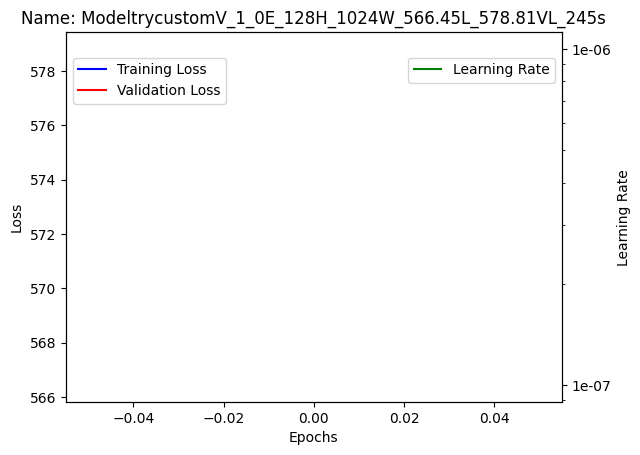

1/1 [==============================] - 1s 1s/step


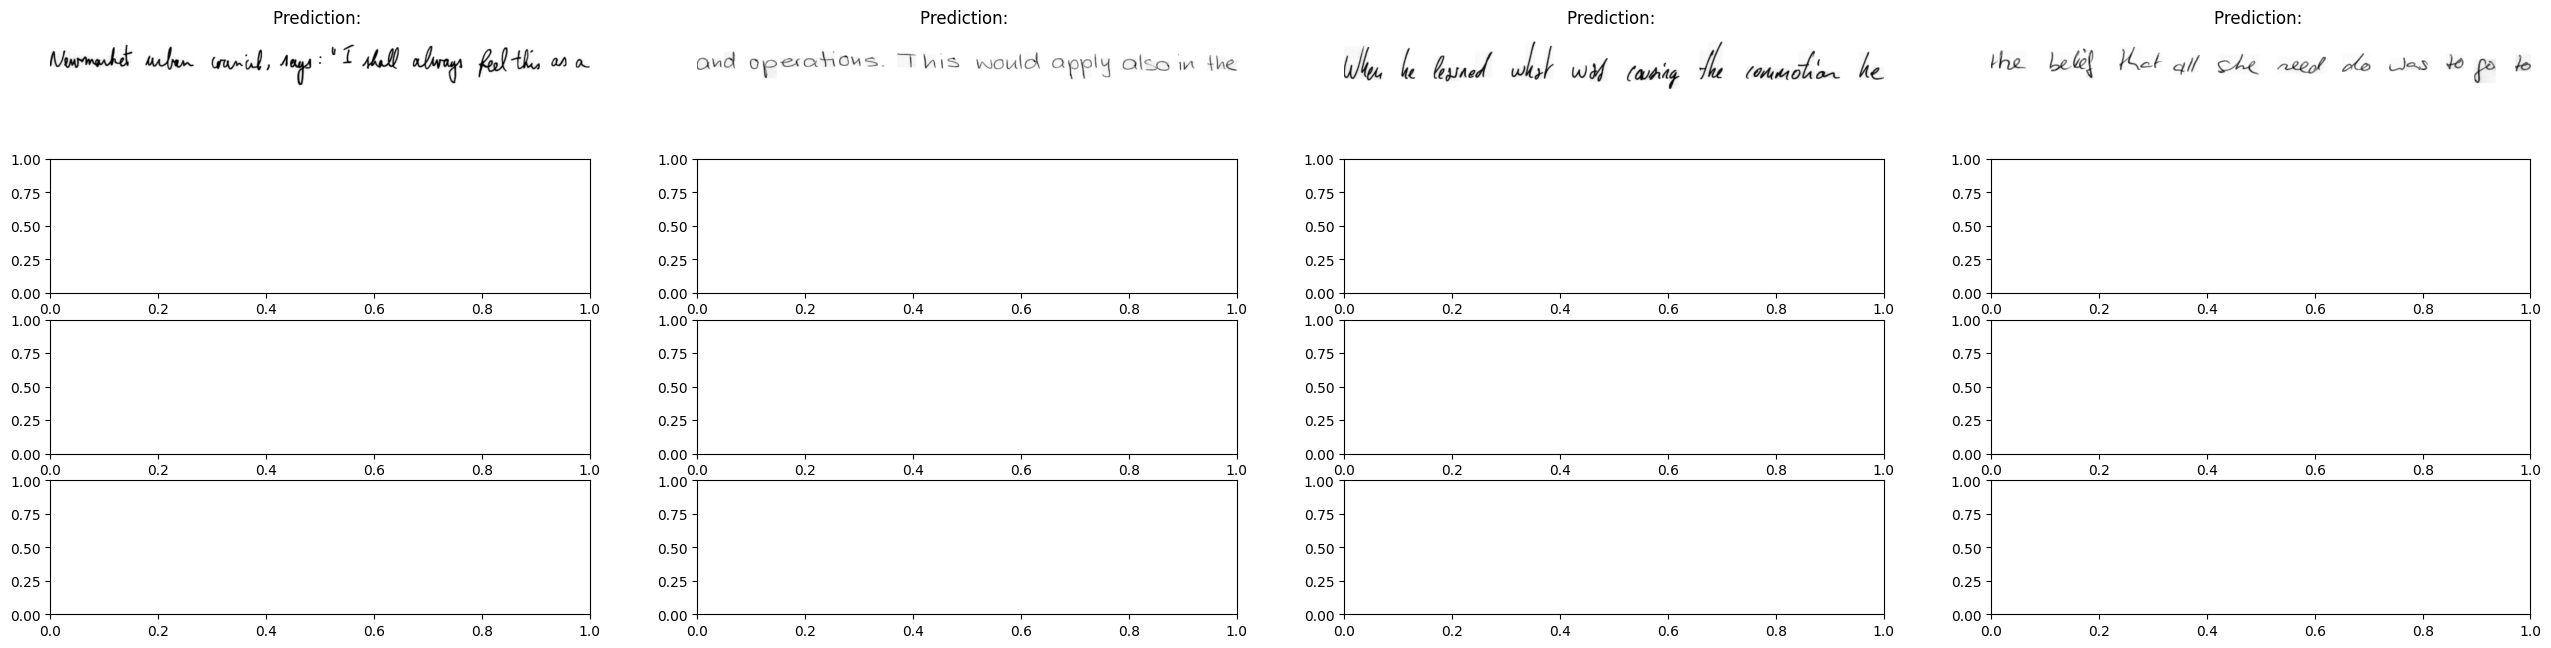

In [20]:
""" Author: Alexej Kravtschenko (main) and Tim Harmling (wrote)
    
Creates a new plot name based on existing names.
This function generates a new plot name by appending a version number to the given model name.
The version number is determined based on existing plot names in the directory.

Args:
    model_name (str): The base model name.
    names (list): A list of existing plot names.
    format (str): The format string for the plot name.

Returns:
    str: The new plot name.
"""
TEST_RESULT_DIR_NAME  = 'test_results'

if not os.path.exists(TEST_RESULT_DIR_NAME):
        create_dir(TEST_RESULT_DIR_NAME)
        
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if files_with_model_name:
            new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
            plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
            plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)
elif SAVE_HISTORY:
            plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
            plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)

### Save Model

In [21]:
if not os.path.exists(MODEL_DIR_NAME):
    create_dir(MODEL_DIR_NAME)
model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
model.save(model_path)
model.save_weights(
    os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"),
    overwrite=True,
    save_format=None,
    options=None,
)
json_string = model.to_json()

with open(os.path.join(model_path, f"{MODEL_NAME}.json"), "w") as f:
    f.write(json_string)

data_to_save = (load_data.max_len, load_data.characters)

with open(os.path.join(model_path, "handwriting_chars.pkl"), "wb") as file:
    pickle.dump(data_to_save, file)

INFO:tensorflow:Assets written to: models/keras/Modeltrycustom/assets


INFO:tensorflow:Assets written to: models/keras/Modeltrycustom/assets


### Launch Tensorboard

In [ ]:
%tensorboard --logdir logs/custom_train_tb